In [1]:
# 1. Підготовка даних
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.interchange.dataframe_protocol import DataFrame
from imblearn.over_sampling import SMOTE
import os
def evaluate_model(x, y, model_):
    y_pred_ = model_.predict(x)
    cm = confusion_matrix(y, y_pred_, labels=model_.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(f'F1_score: {f1_score(y, y_pred_)}')
os.chdir("D:\PycharmProjects\MachineLearning")
df = pd.read_csv('adult.csv')
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [2]:
# 2. Перевірка балансу класів
df.groupby('income')['age'].count()

income
0    24720
1     7841
Name: age, dtype: int64

Класи не є збалансованами, що може привести до зсуву моделі в бік більшого класу і передбачати лише його. Довіряти 
такій моделі не можна. Для балансування можна штучно збільшити кількість об'єктів меншого класу або зменшити 
кількість об'єктів більшого класу. Accuracy використовувати недоцільно, бо вона чутлива до незбалансованості. Для її 
заміни краще використовувати F-score

In [3]:
# 3. Вибір метрики
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

Далі я розділяю дані на тренувальні та тестові вибірки. Також я все-таки віришив збалансувати класи, методом 
збільшення кількості об'єктів меншого класу для покращення результатів

In [4]:
# 4. Розділення даних
from sklearn.model_selection import train_test_split
X = df.loc[:, df.columns != 'income']
Y = df['income']
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [5]:
# 5. Навчання логістичної регресії без регуляризації
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='newton-cholesky')
log_model.fit(x_train, y_train)
print(log_model.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cholesky', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Train: 


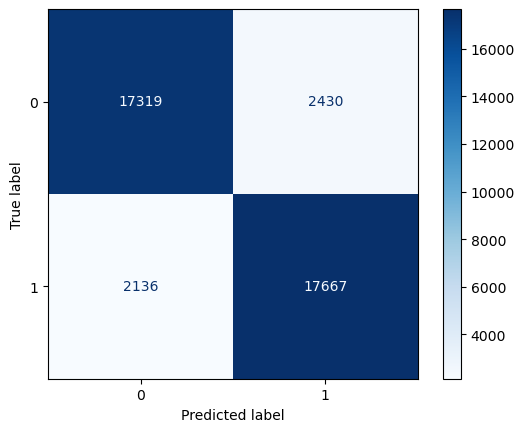

F1_score: 0.8855639097744361
Test: 


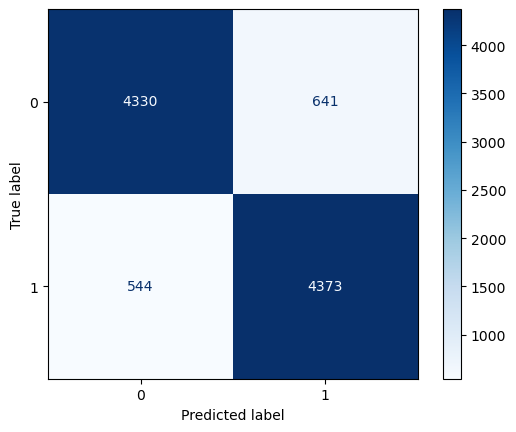

F1_score: 0.8806766690162119


In [6]:
# 6. Оцінка якості моделі
print("Train: ")
evaluate_model(x_train, y_train, log_model)
print("Test: ")
evaluate_model(x_test, y_test, log_model)

Тут я задаю декілька значеня для кількості фолдів для розбиття, перебираю їх у циклі і виводжу середнє значення 
оцінки при кожному типі розбиття

In [33]:
# 7. Оцінка якості моделі на основі перехресної перевірки
from sklearn.model_selection import cross_validate, KFold
for cv in [3, 5, 7, 10]:
    scores = cross_validate(log_model, X, Y, scoring='f1', cv=KFold(n_splits=cv, shuffle=True), return_train_score=True)
    print(f"cv = {cv}. Test_F1_score: {scores['test_score'].mean()}. Train_F1_score: {scores['train_score'].mean()}.")

cv = 3. Test_F1_score: 0.8844733067445012. Train_F1_score: 0.8845312674965157.
cv = 5. Test_F1_score: 0.8841297425775909. Train_F1_score: 0.8846541056848561.
cv = 7. Test_F1_score: 0.8843773956126161. Train_F1_score: 0.8846476880469696.
cv = 10. Test_F1_score: 0.8843661567155012. Train_F1_score: 0.884634262553033.


Тут я вирішив додати графік з learning_curve, щоб подивитися чи вистачає нам даних, та яке оптимальне співвідношення 
розбиття на тренувальні та тестові дані.

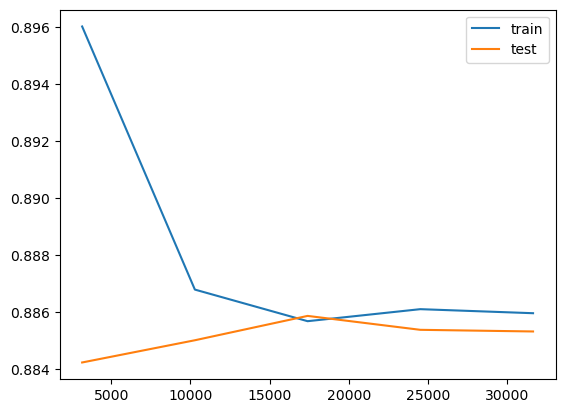

In [8]:
from sklearn.model_selection import learning_curve
sizes, train_score, test_score = learning_curve(log_model, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5),cv=KFold(n_splits=5,shuffle=True), scoring='f1')
plt.plot(sizes, train_score.mean(1), label='train')
plt.plot(sizes, test_score.mean(1), label='test')
plt.legend()

Тут я вручну перебираю значення параметра C, а також додав графік для візуалізації залежності якості моделі від C.

(0.5, 1.0)

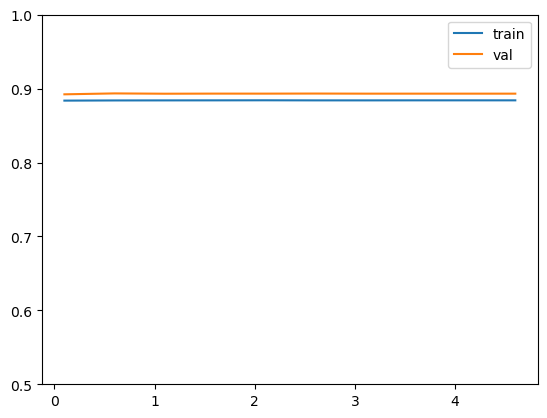

In [9]:
# 8. Навчання логістичної регресії з регуляризацією
x1_train, x_val, y1_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
C_values = np.arange(0.1, 5.1, 0.5)
train_scores = []
val_scores = []
for c in C_values:  
    log_reg_model = LogisticRegression(solver='newton-cholesky', penalty='l2', C=c)
    log_reg_model.fit(x1_train, y1_train)
    y_pred = log_reg_model.predict(x1_train)
    train_scores.append(f1_score(y1_train, y_pred))
    y_pred = log_reg_model.predict(x_val)
    val_scores.append(f1_score(y_val, y_pred))
plt.plot(C_values, train_scores, label='train')
plt.plot(C_values, val_scores, label='val')
plt.legend()
plt.ylim(0.5, 1)

Тут я вже в автоматичному режимі підбираю значення параметру C за допомогою validation_curve. Цей варіант підходить 
для пошуку оптимального значення одного параметра.

(0.8, 1.0)

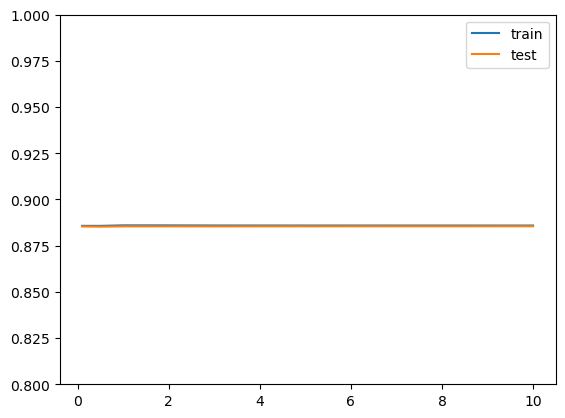

In [10]:
from sklearn.model_selection import validation_curve
log_reg_model = LogisticRegression(solver='newton-cholesky', penalty='l2')
alpha_range = [0.1, 0.5, 1, 2, 3, 5, 10]
train_score, test_score = validation_curve(log_reg_model, x_train, y_train, scoring='f1', param_name='C',
param_range=alpha_range, cv=(KFold(n_splits=5,shuffle=True)))
plt.plot(alpha_range, train_score.mean(1), label='train')
plt.plot(alpha_range, test_score.mean(1), label='test')
plt.legend()
plt.ylim(0.8, 1)

Цей варіант в принципі є альтернативую validation_curve, але у GridSearchCV ми можемо підбирати не один параметр, а 
їх комбінації. Так як для логістичної регресії ми зазвичай підбираємо тільки C, особливої різниці немає. Але це 
доцільно для моделей, у яких багато різних гіперпараметрів, і вручну або за допомогою validation_curve підбирати їх 
не дуже зручно і може зайняти багато часу. 

{'C': 1}
0.8850477043695942


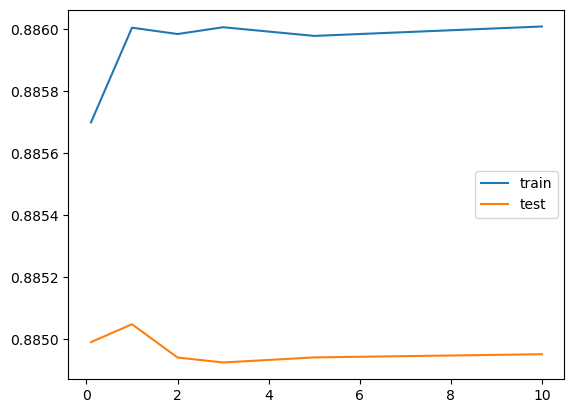

In [11]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(log_reg_model, param_grid={'C': [0.1, 1, 2, 3, 5, 10]}, scoring='f1', cv=(KFold(n_splits=5)), return_train_score=True)
search.fit(x_train, y_train)
results = search.cv_results_
train_score = results['mean_train_score']
test_score = results['mean_test_score']
plt.plot([0.1, 1, 2, 3, 5, 10], train_score, label='train')
plt.plot([0.1, 1, 2, 3, 5, 10], test_score, label='test')
plt.legend()
print(search.best_params_)
print(search.best_score_)

Train: 


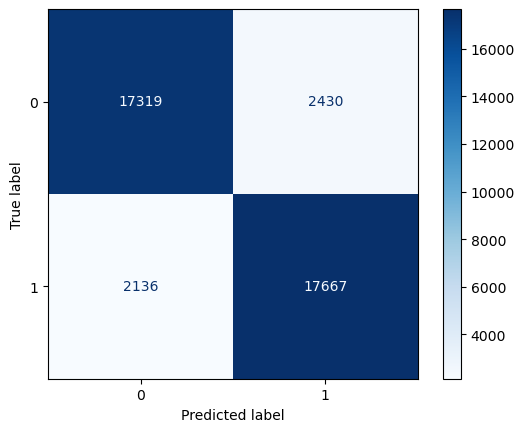

F1_score: 0.8855639097744361
Test: 


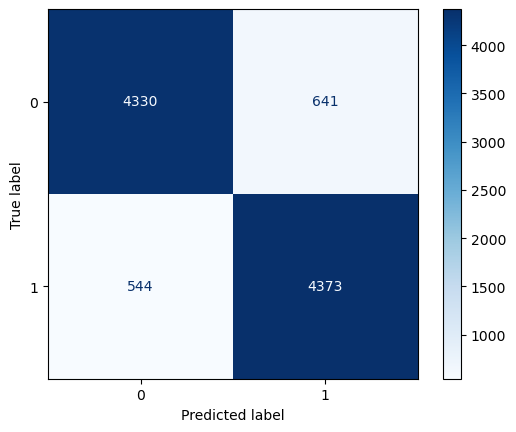

F1_score: 0.8806766690162119


In [12]:
# 9. Оцінка якості моделі з регуляризацією
log_reg_model = search.best_estimator_
log_reg_model.fit(x_train, y_train)
print("Train: ")
evaluate_model(x_train, y_train, log_reg_model)
print("Test: ")
evaluate_model(x_test, y_test, log_reg_model)

In [13]:
# 10. Відбір ознак
# model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000)
# model.fit(x_train, y_train)
# cf = pd.Series(model.coef_[0] * 10, index=x_train.columns)
# print(cf.sort_values(ascending=False))
# df = df.drop(columns=df.filter(like='capital-loss').columns)
# X = df.loc[:, df.columns != 'income']
# Y = df['income']
# smote = SMOTE()
# X, Y = smote.fit_resample(X, Y)
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
# log_reg_model.fit(x_train, y_train)
# print("Train: ")
# evaluate_model(x_train, y_train, log_reg_model)
# print("Test: ")
# evaluate_model(x_test, y_test, log_reg_model)

Train: 


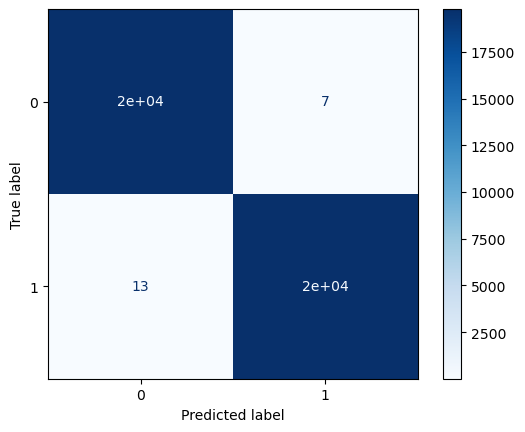

F1_score: 0.9994949494949495
Test: 


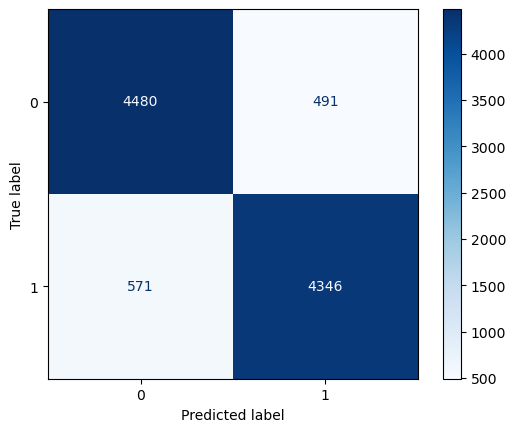

F1_score: 0.8911215911420955


In [15]:
# 11. Навчання додаткового класифікатора
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(40)
forest_model.fit(x_train, y_train)
print("Train: ")
evaluate_model(x_train, y_train, forest_model)
print("Test: ")
evaluate_model(x_test, y_test, forest_model)

Спочатку я намагався використати GridSearchCV, але через те, що датасет доволі великий, а кількість комбінацій між 
параметрами величезна, я все ж вирішив використати RandomizedSearchCV, щоб зменшити нач на пошук оптимальної 
комбінації гіперпараметрів.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}
search = RandomizedSearchCV(forest_model, param_grid, scoring='f1', 
return_train_score=True, n_iter=20)
search.fit(x1_train, y1_train)

0.8977660450807203


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params__'

In [27]:
print(search.best_score_)
print(search.best_params_)

0.8977660450807203
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}


Train: 


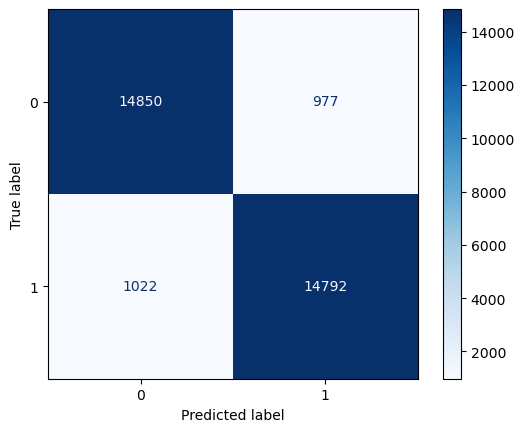

F1_score: 0.9367064560048127
Validate: 


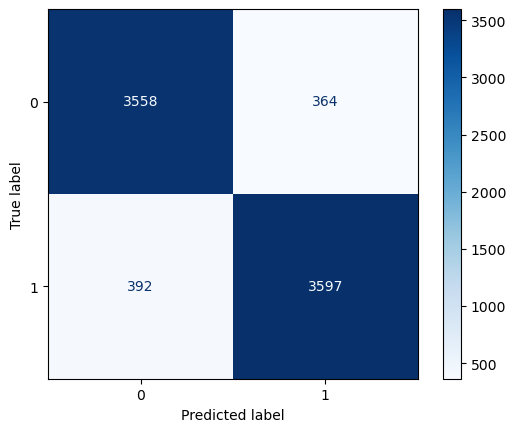

F1_score: 0.9049056603773585


In [28]:
forest_model = search.best_estimator_
print("Train: ")
evaluate_model(x1_train, y1_train, forest_model)
print("Validate: ")
evaluate_model(x_val, y_val, forest_model)

In [31]:
scores = cross_validate(forest_model, X, Y, scoring='f1', cv=KFold(n_splits=5, shuffle=True), return_train_score=True)
print(f"Test_F1_score: {scores['test_score'].mean()}. Train_F1_score: {scores['train_score'].mean()}.")

Test_F1_score: 0.898507177069883. Train_F1_score: 0.9372499002441141.


Train: 
LogisticRegression


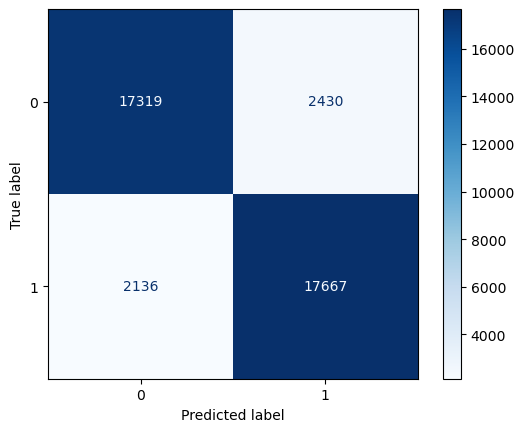

F1_score: 0.8855639097744361
RandomizedForestClassifier


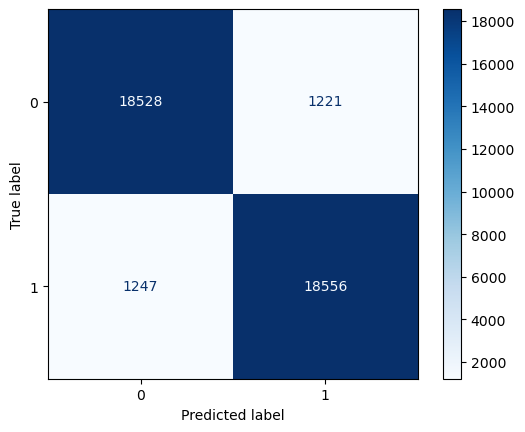

F1_score: 0.9376452753916119
Test: 
LogisticRegression


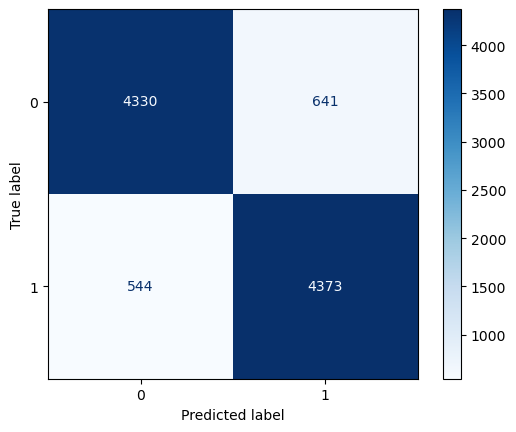

F1_score: 0.8806766690162119
RandomizedForestClassifier


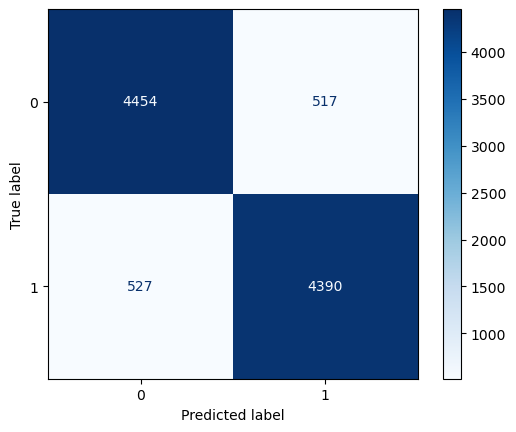

F1_score: 0.8937296416938111


In [32]:
# 12. Порівняння класифікаторів
forest_model.fit(x_train, y_train)
log_model.fit(x_train, y_train)
print("Train: ")
print("LogisticRegression")
evaluate_model(x_train, y_train, log_model)
print("RandomizedForestClassifier")
evaluate_model(x_train, y_train, forest_model)
print("Test: ")
print("LogisticRegression")
evaluate_model(x_test, y_test, log_model)
print("RandomizedForestClassifier")
evaluate_model(x_test, y_test, forest_model)

За результатами можна сказати, що випадковий ліс показує трохи кращі результати на тестовій вибірці, проте він значно
 схильніший до перенавчання. Якщо на логістичній регресії перенавчання майже немає, то тут воно складає близько 4%.